In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/pufr_fixed_ttbar/dataset_mu200_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_label_sig = ak.ones_like(jet_pt_sig)

# Load background sample into memory
with uproot.open("ntuples/pufr_fixed_ttbar/dataset_mu200_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_label_bkg = ak.zeros_like(jet_pt_bkg)

In [3]:
class Jet:
    def __init__(self, feats):
        pt, eta, phi, m, pufr, label = feats
        self.pt = pt
        self.eta = eta
        self.phi = phi
        self.m = m
        self.pufr = pufr
        self.label = label
        
    def __len__(self):
        return len(self.pt)
        
    def apply_mask(self, mask):
        self.pt = self.pt[mask]
        self.eta = self.eta[mask]
        self.phi = self.phi[mask]
        self.m = self.m[mask]
        self.pufr = self.pufr[mask]
        self.label = self.label[mask]
        
    def return_event_idx(self):
        sig = (self.label==1)
        sig_event = ak.mean(sig,axis=1)==1
        bkg_event = ak.mean(sig,axis=1)==0
        return sig_event,bkg_event
    
    def return_mean(self):
        return [ak.mean(self.pt), ak.mean(self.eta), ak.mean(self.phi), ak.mean(self.m)]
    
    def return_std(self):
        return [ak.std(self.pt), ak.std(self.eta), ak.std(self.phi), ak.std(self.m)]
    
    def apply_norm(self,mean_list,std_list):
        self.pt = (self.pt-mean_list[0]) / std_list[0]
        self.eta = (self.eta-mean_list[1]) / std_list[1]
        self.phi = (self.phi-mean_list[2]) / std_list[2]
        self.m = (self.m-mean_list[3]) / std_list[3]
        
    def return_subset(self, start_idx, stop_idx):
        pt = self.pt[start_idx:stop_idx]
        eta = self.eta[start_idx:stop_idx]
        phi = self.phi[start_idx:stop_idx]
        m = self.m[start_idx:stop_idx]
        pufr = self.pufr[start_idx:stop_idx]
        label = self.label[start_idx:stop_idx]
        feats = [pt,eta,phi,m,pufr,label]
        return Jet(feats)
    
    def return_tensors(self):
        data = ak.concatenate([self.pt[:,:,np.newaxis],self.eta[:,:,np.newaxis],self.phi[:,:,np.newaxis],self.m[:,:,np.newaxis]], axis=2)
        labels = ak.mean(self.label,axis=1)
        #data = torch.nested.nested_tensor(ak.to_list(data))
        #labels = torch.Tensor(labels).reshape(-1,1)
        return data, labels

feats_sig = [jet_pt_sig, jet_eta_sig, jet_phi_sig, jet_m_sig, jet_pufr_sig, jet_label_sig]
feats_bkg = [jet_pt_bkg, jet_eta_bkg, jet_phi_bkg, jet_m_bkg, jet_pufr_bkg, jet_label_bkg]

feats = []
for i in range(len(feats_sig)):
    feats.append(ak.concatenate([feats_sig[i],feats_bkg[i]], axis=0))
jets = Jet(feats)
jets_ALL = Jet(feats)

print(jets.pt)
print(jets.eta)
print(jets.phi)
print(jets.m)
print(jets.pufr)
print(jets.label)

[[287, 218, 184, 147, 144, 106, ..., 27.4, 26.8, 26.6, 26.3, 25.7, 25.1], ...]
[[-1.2, 1.37, 0.962, -1.13, 0.677, -3.12, ..., 5.8, 5.91, -6.27, 7, 0.657], ...]
[[2.06, 4.71, 5.34, 1.43, 6.08, ..., 0.404, 1.67, 0.168, 3.55, 4.99], ...]
[[95.6, 80.4, 87.4, 65, 63.9, 57.8, ..., 18.8, 19.3, 16.5, 13.6, 12.1], ...]
[[0.0822, 0.00538, 0.247, 0.022, 0.0783, 0.976, ..., 1, 1, 1, 1, 1, 1], ...]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ...]


In [4]:
shuffled_idx = np.random.permutation(len(jets))
jets.apply_mask(shuffled_idx)
jets_ALL.apply_mask(shuffled_idx)

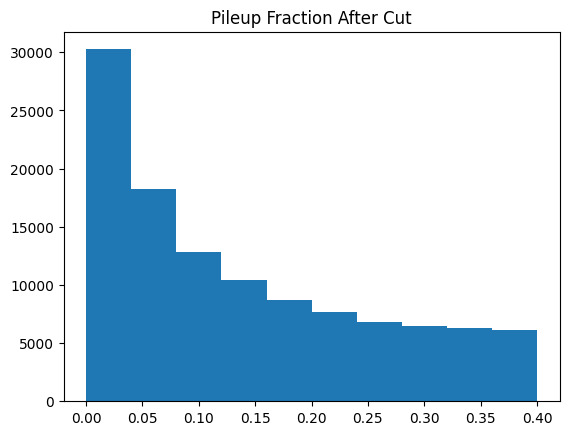

In [5]:
# Get Jets that pass a pufr cut
pufr_cut = 0.4
mask = (jets.pufr<pufr_cut)

# Assemble features of selected jets only
jets.apply_mask(mask)

# Verify 
pu_score = ak.ravel(jets.pufr)
plt.title("Pileup Fraction After Cut")
plt.hist(pu_score)
plt.show()

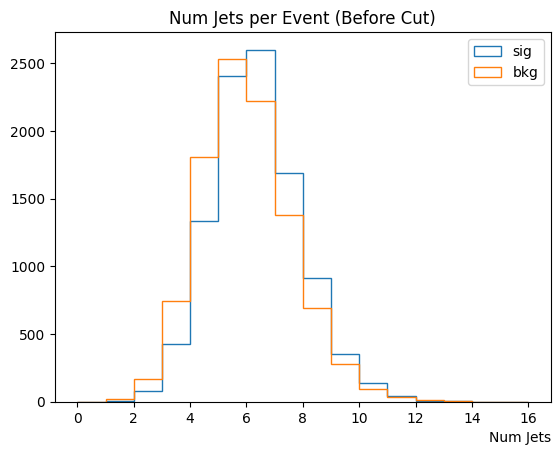

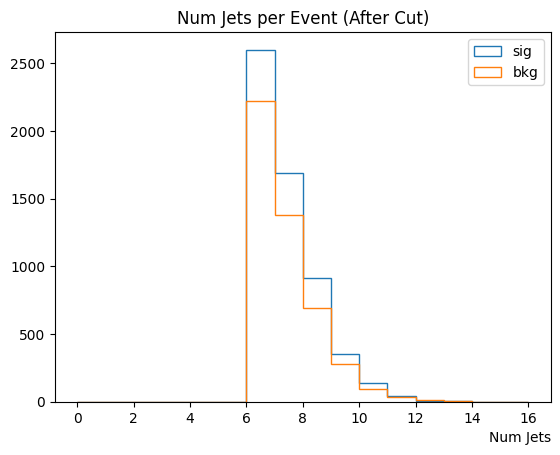

In [6]:
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
plt.title('Num Jets per Event (Before Cut)')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=16,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=16,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

# Require at least six jets
mask = h_num_jets>=6
jets.apply_mask(mask)
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
plt.title('Num Jets per Event (After Cut)')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=16,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=16,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

In [7]:
def test_val_train_split(Jets):
    num_events = len(Jets)
    train_split = int(0.7*num_events)
    test_split = int(0.75*num_events)
    
    X_train = Jets.return_subset(0,train_split)
    X_val = Jets.return_subset(train_split,test_split)
    X_test = Jets.return_subset(test_split,num_events)
    
    mean_list = X_train.return_mean()
    std_list = X_train.return_std()
    
    X_train.apply_norm(mean_list, std_list)
    X_val.apply_norm(mean_list, std_list)
    X_test.apply_norm(mean_list, std_list)
    
    X_train, y_train = X_train.return_tensors()
    X_val, y_val = X_val.return_tensors()
    X_test, y_test = X_test.return_tensors()
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train_nocut, y_train_nocut, X_val_nocut, y_val_nocut, X_test_nocut, y_test_nocut = test_val_train_split(jets_ALL)
X_train_cut, y_train_cut, X_val_cut, y_val_cut, X_test_cut, y_test_cut = test_val_train_split(jets)

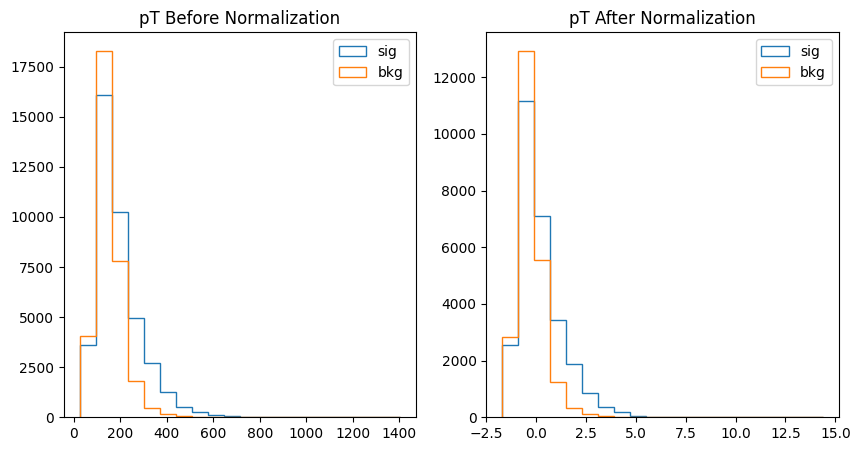

Before Mean:  171.1910795532883
Before STD:  86.32530823722024
After Mean:  -1.7177974835204956e-06
After STD:  1.0000020936723002


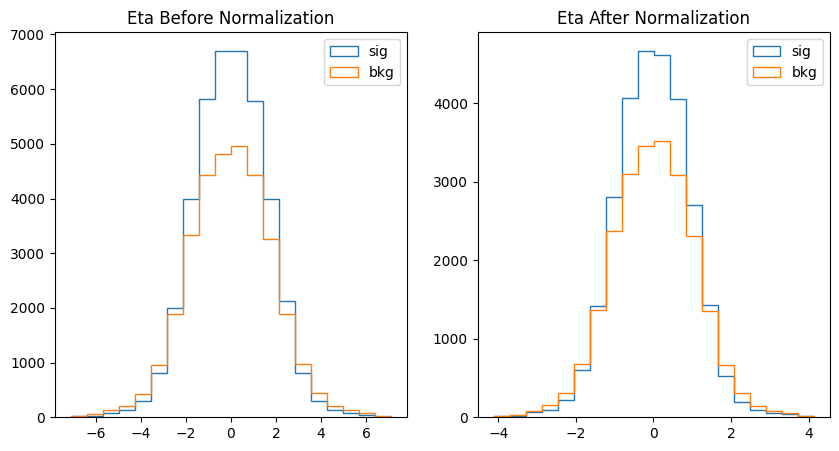

Before Mean:  0.006419476275442058
Before STD:  1.717243102690504
After Mean:  -2.739448038404696e-09
After STD:  1.0000008435397012


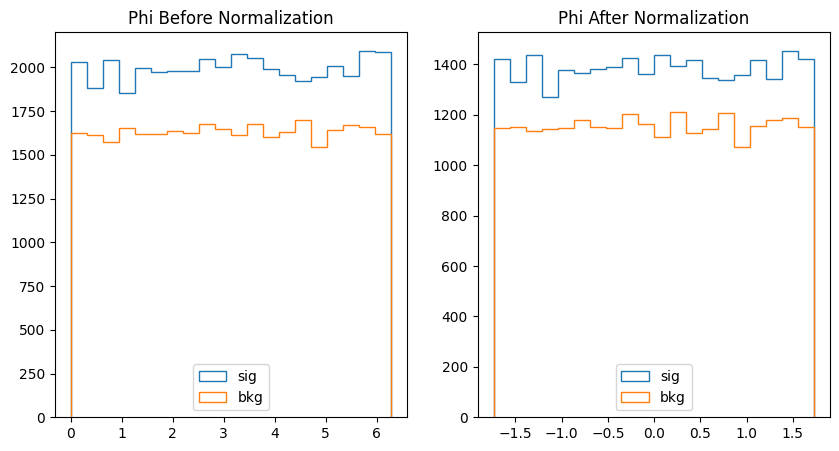

Before Mean:  3.1541308337929133
Before STD:  1.8132839644437755
After Mean:  3.907552489769917e-06
After STD:  0.9999995646790096


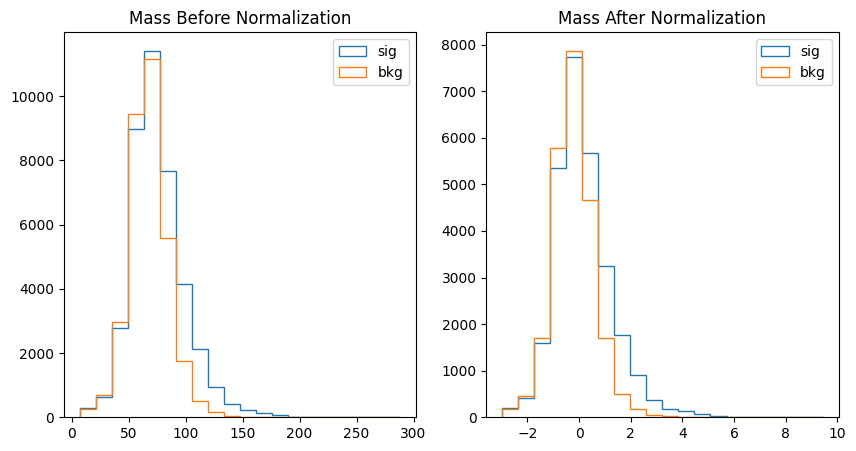

Before Mean:  71.72376258100097
Before STD:  21.609357014122118
After Mean:  4.194376702673263e-06
After STD:  0.9999551949157202


/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [8]:
# Validation plots
var_list = ['pT','Eta','Phi','Mass']
var_list_before = [jets.pt,jets.eta,jets.phi,jets.m]
var_list_after = [X_train_cut[:,:,0],X_train_cut[:,:,1],X_train_cut[:,:,2],X_train_cut[:,:,3]]

for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = var_list_before[i]
    mini=ak.min(var1)
    maxi=ak.max(var1)
    sig,bkg = jets.return_event_idx()
    ax1.hist(ak.ravel(var1[sig]),histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax1.hist(ak.ravel(var1[bkg]),histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    var2 = var_list_after[i]
    mini=ak.min(var2)
    maxi=ak.max(var2)
    sig = (y_train_cut==1)
    bkg = ~sig
    ax2.hist(ak.ravel(var2[sig]),histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax2.hist(ak.ravel(var2[bkg]),histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

# Convert to torch.Tensor()
X_train_cut = torch.nested.nested_tensor(ak.to_list(X_train_cut))
y_train_cut = torch.Tensor(y_train_cut).reshape(-1,1)
X_val_cut = torch.nested.nested_tensor(ak.to_list(X_val_cut))
y_val_cut = torch.Tensor(y_val_cut).reshape(-1,1)
X_test_cut = torch.nested.nested_tensor(ak.to_list(X_test_cut))
y_test_cut = torch.Tensor(y_test_cut).reshape(-1,1)

X_train_nocut = torch.nested.nested_tensor(ak.to_list(X_train_nocut))
y_train_nocut = torch.Tensor(y_train_nocut).reshape(-1,1)
X_val_nocut = torch.nested.nested_tensor(ak.to_list(X_val_nocut))
y_val_nocut = torch.Tensor(y_val_nocut).reshape(-1,1)
X_test_nocut = torch.nested.nested_tensor(ak.to_list(X_test_nocut))
y_test_nocut = torch.Tensor(y_test_nocut).reshape(-1,1)

In [9]:
class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_postprocess = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        jet_aggregated = jet_embedding.sum(dim=0)
        output = F.sigmoid(self.jet_postprocess(jet_aggregated))
        return output

In [10]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'test_loss':[]}

    cum_loss_train = []
    cum_loss_val = []
    
    for e in range(epochs):     
        num_train = X_train.size(0)
        model.train()
        for event in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[event].to(device))
            loss = loss_fn(output, y_train[event].to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['test_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tTest Loss:',round(float(np.mean(cum_loss_val)),4))

    return history   

In [11]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Training Baseline
Epoch: 1 	Train Loss: 0.6792 	Test Loss: 0.879
Epoch: 2 	Train Loss: 0.6564 	Test Loss: 0.841
Epoch: 3 	Train Loss: 0.6474 	Test Loss: 0.8167
Epoch: 4 	Train Loss: 0.6422 	Test Loss: 0.7993
Epoch: 5 	Train Loss: 0.6384 	Test Loss: 0.7855
Epoch: 6 	Train Loss: 0.6355 	Test Loss: 0.7736
Epoch: 7 	Train Loss: 0.633 	Test Loss: 0.7631
Epoch: 8 	Train Loss: 0.6307 	Test Loss: 0.7535
Epoch: 9 	Train Loss: 0.6287 	Test Loss: 0.7448
Epoch: 10 	Train Loss: 0.6268 	Test Loss: 0.7368
Epoch: 11 	Train Loss: 0.625 	Test Loss: 0.7293
Epoch: 12 	Train Loss: 0.6233 	Test Loss: 0.7223
Epoch: 13 	Train Loss: 0.6217 	Test Loss: 0.7157
Epoch: 14 	Train Loss: 0.6201 	Test Loss: 0.7096
Epoch: 15 	Train Loss: 0.6186 	Test Loss: 0.704
Epoch: 16 	Train Loss: 0.6171 	Test Loss: 0.6988
Epoch: 17 	Train Loss: 0.6157 	Test Loss: 0.6939
Epoch: 18 	Train Loss: 0.6143 	Test Loss: 0.6894
Epoch: 19 	Train Loss: 0.613 	Test Loss: 0.6852
Epoch: 20 	Train Loss: 0.6117 	Test Loss: 0.6813
Epoch: 21 	Train 

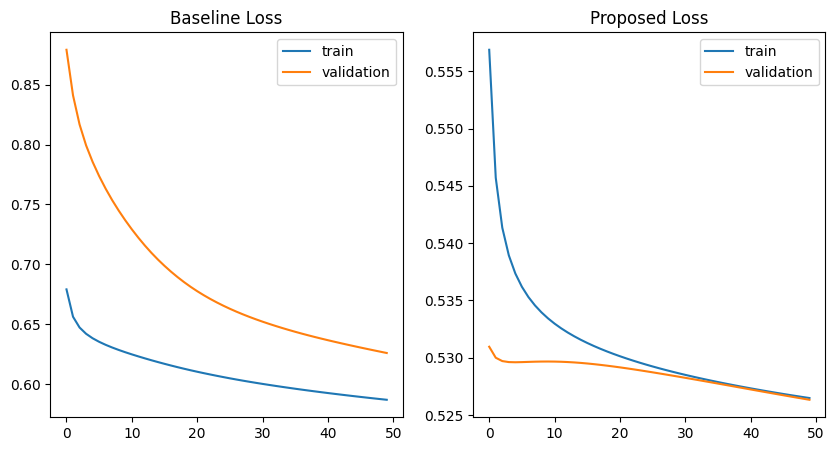

In [12]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

# Train baseline model with pt,eta,phi,m
print("Training Baseline")
baseline = Model(4,256,1).to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.0001)
data = [X_train_nocut, y_train_nocut, X_val_nocut, y_val_nocut]
baseline_history = train(baseline, data, epochs=50)
print()

# Train upgraded model with pt,eta,phi,m,pufr
print("Training Proposed")
model = Model(4,256,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
data = [X_train_cut, y_train_cut, X_val_cut, y_val_cut]
model_history = train(model, data, epochs=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_loss'],label='train')
ax1.plot(baseline_history['test_loss'],label='validation')
ax1.set_title("Baseline Loss")
ax1.legend()
ax2.plot(model_history['train_loss'],label='train')
ax2.plot(model_history['test_loss'],label='validation')
ax2.set_title("Proposed Loss")
ax2.legend()
plt.show()

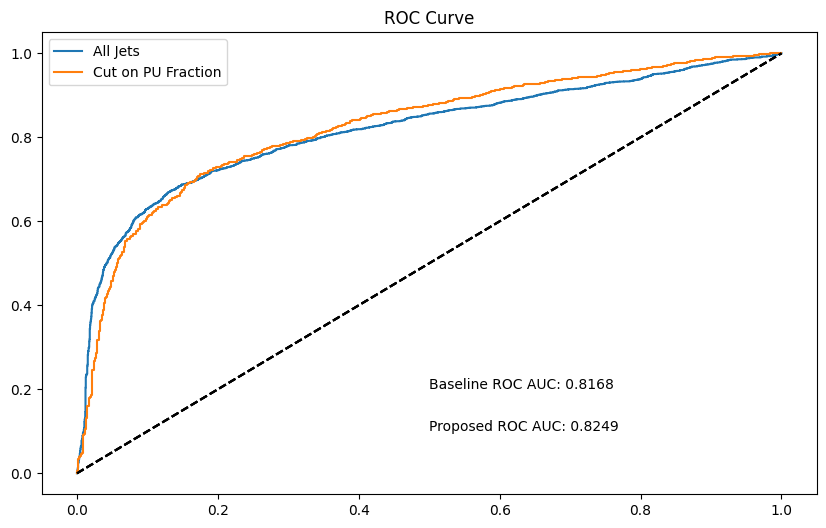

In [13]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

num_test = X_test_nocut.size(0)

baseline.to(device)
baseline.eval()
y_pred_nocut = []
for event in range(num_test):
    y_pred_nocut.append(baseline(X_test_nocut[event].to(device)).detach().cpu().numpy())
y_pred_nocut = np.array(y_pred_nocut)
fpr, tpr, thresholds = roc_curve(y_test_nocut, y_pred_nocut)
ax1.plot(fpr,tpr, label="All Jets")
ax1.plot([[0,0],[1,1]],'--',color='k')
AUC = "Baseline ROC AUC: " + str(round(roc_auc_score(y_test_nocut, y_pred_nocut),4))
ax1.text(0.5,0.2,AUC)

num_test = X_test_cut.size(0)

model.to(device)
model.eval()
y_pred_cut = []
for event in range(num_test):
    y_pred_cut.append(model(X_test_cut[event].to(device)).detach().cpu().numpy())
y_pred_cut = np.array(y_pred_cut)
fpr, tpr, thresholds = roc_curve(y_test_cut, y_pred_cut)
ax1.plot(fpr,tpr, label="Cut on PU Fraction")
ax1.plot([[0,0],[1,1]],'--',color='k')
ax1.set_title("ROC Curve")
AUC = "Proposed ROC AUC: " + str(round(roc_auc_score(y_test_cut, y_pred_cut),4))
ax1.text(0.5,0.1,AUC)
ax1.legend()
plt.show()

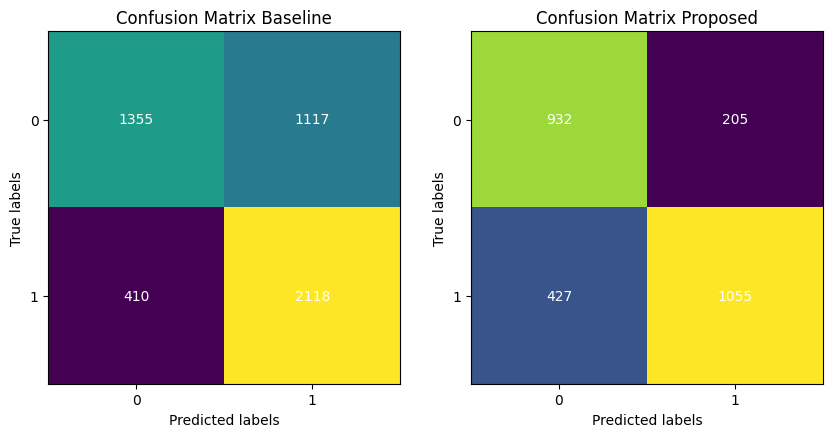

Binary Accuracy of Baseline:  0.6946
Binary Accuracy of Proposed:  0.7586865215731196

F1 Score of Baseline:  0.735033836543467
F1 Score of Proposed:  0.7695113056163384


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

threshold = 0.5

y_Pred_cut = y_pred_cut > threshold
y_Pred_nocut = y_pred_nocut > threshold

cm =confusion_matrix(y_test_nocut, y_Pred_nocut)
ax1.imshow(cm)
ax1.set_title("Confusion Matrix Baseline")
#ax1.set_colorbar()
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
for i in range(len(cm)):
    for j in range(len(cm)):
        ax1.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")

cm =confusion_matrix(y_test_cut, y_Pred_cut)
ax2.imshow(cm)
ax2.set_title("Confusion Matrix Proposed")
#ax2.colorbar()
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
for i in range(len(cm)):
    for j in range(len(cm)):
        ax2.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
plt.show()

print("Binary Accuracy of Baseline: ", accuracy_score(y_test_nocut, y_Pred_nocut))
print("Binary Accuracy of Proposed: ", accuracy_score(y_test_cut, y_Pred_cut))
print()
print("F1 Score of Baseline: ", f1_score(y_test_nocut, y_Pred_nocut))
print("F1 Score of Proposed: ", f1_score(y_test_cut, y_Pred_cut))